In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\pu_with_proj.geojson').to_crs(epsg=3857)
hs_2028_geo.head(2)

,pu_2324_84,student_gen,basez,final_proj,geometry
0,1,0,0.0,0.0,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ..."
1,2,0,4.0,4.0,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ..."


In [20]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[6,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

In [9]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\pu_2324_848.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head(2)

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"MULTIPOLYGON (((-8.77e+06 4.33e+06, -8.77e+06 ..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ..."


In [122]:
def score_candidate(candidate):
    school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
    capacities = [1100,1300,1100,1050,1100,1100]

    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'coefficient':[1,1,1,1,1,1]
                            })                               #initialize counts dataframe

    
    candidate_geom = candidate['geometry']
    dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    

    for i in range(10):                                      #iterative boundary assignment (running 10x)
        assignments = []
        for pu in hs_2028_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):                               #5 existing schools and 1 new
                dist = centroid.distance(dps_base_hs.loc[j,'geometry'])
                score = dist * counts.loc[j,'coefficient']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)                        #collect hs assignments based on min distance score
        hs_2028_geo['assign'] = assignments

        for i,school in enumerate(school_names):
            assigned_students = hs_2028_geo.loc[hs_2028_geo['assign'] == school, 'final_proj'].sum()
            counts.loc[i, 'count'] = assigned_students                    #sum up counts for all high schools and update coefficients
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.01

    objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['final_proj']*objective['distance']).sum()/(10**7)

    return objective_score,counts

In [123]:
candidate = dps_pu.loc[142]
score_candidate(candidate)

(2.9218887856046365,
                   school  capacity  count  coefficient
 0   Southern High School      1100   1690     1.043877
 1   Hillside High School      1300   1942     1.042063
 2   Northern High School      1100   1252     1.014252
 3  Riverside High School      1050    292     0.873295
 4     Jordan High School      1100   1205     1.008290
 5        New High School      1100    634     0.945587)

<Axes: >

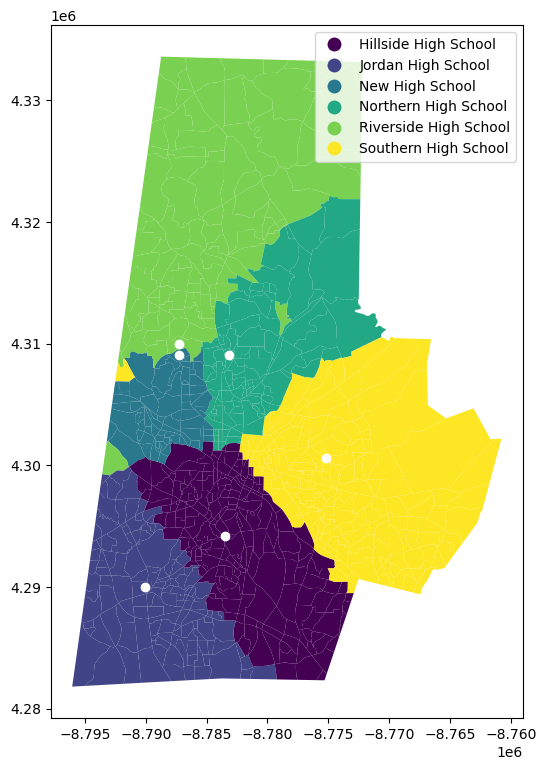

In [124]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [109]:
dps_pu.sort_values(by='score')

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry,score
79,80,80,2.028357e+06,816586.202368,0.0,181,181,101,101,PU181,Central,9319.637897,5.514672e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",2.682187
45,46,46,2.031317e+06,816410.519273,0.0,300,300,57,57,PU300,Central,6551.010024,2.385070e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",2.689947
316,317,317,2.029414e+06,814614.301147,0.0,189,189,414,414,PU189,Southwest,5311.464631,1.228714e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",2.690414
317,318,318,2.030401e+06,815463.480829,0.0,822,822,415,415,PU822,Central,7103.722578,2.904230e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",2.691341
319,320,320,2.031606e+06,817694.046979,0.0,301,301,418,418,PU301,Central,6109.796132,2.239556e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",2.693886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,743,743,2.029888e+06,801739.319414,0.0,360,360,380,979,PU360,Southeast,5325.583425,1.208630e+06,"MULTIPOLYGON (((-8.78e+06 4.29e+06, -8.78e+06 ...",7.365916
289,290,290,2.028115e+06,803241.889114,0.0,360,360,380,380,PU360,Southeast,12561.928741,8.118411e+06,"MULTIPOLYGON (((-8.78e+06 4.3e+06, -8.78e+06 4...",7.365916
204,205,205,2.029133e+06,839273.227477,0.0,501,501,267,267,PU501,North,7644.237898,2.442300e+06,"MULTIPOLYGON (((-8.78e+06 4.31e+06, -8.78e+06 ...",7.365916
506,507,507,2.009871e+06,790418.494931,0.0,242,242.0,677,677,PU242.0,Southwest,12968.993123,9.879656e+06,"MULTIPOLYGON (((-8.79e+06 4.29e+06, -8.79e+06 ...",7.365916


<Axes: >

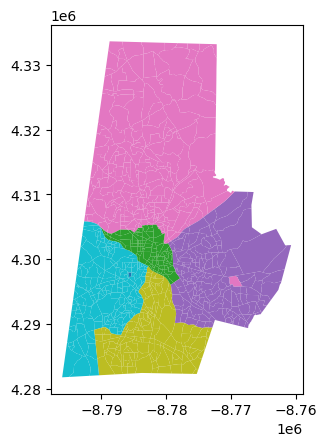

In [108]:
dps_pu.plot(
    column = 'Region'
)